# Topological Functions

In [6]:
from itertools import chain, combinations, permutations, product, pairwise
from math import prod, log
from copy import deepcopy
import networkx as nx
from fractions import Fraction
import json
from operator import add

def hs_array_to_fr(hs_array):
    return prod([pow(dims[d], hs_array[d]) for d in range(len(dims))])

def hs_array_to_cents(hs_array):
    return (1200 * log(hs_array_to_fr(hs_array), 2))

def expand_pitch(hs_array):
    expanded_pitch = list(hs_array)
    frequency_ratio = hs_array_to_fr(hs_array)
    if frequency_ratio < 1:
        while frequency_ratio < 1:
            frequency_ratio *= 2
            expanded_pitch[0] += 1
    elif frequency_ratio >= 2:
        while frequency_ratio >= 2:
            frequency_ratio *= 1/2
            expanded_pitch[0] += -1
    return tuple(expanded_pitch)

def expand_chord(chord):
    return tuple(expand_pitch(p) for p in chord)

def collapse_pitch(hs_array):
    collapsed_pitch = list(hs_array)
    collapsed_pitch[0] = 0
    return tuple(collapsed_pitch)

def collapse_chord(chord):
    return tuple(collapse_pitch(p) for p in chord)

def transpose_pitch(pitch, trans):
    return tuple(map(add, pitch, trans))

def transpose_chord(chord, trans):
    return tuple(transpose_pitch(p, trans) for p in chord)

def cent_difference(hs_array1, hs_array2):
    return hs_array_to_cents(hs_array2) - hs_array_to_cents(hs_array1)

def pitch_difference(hs_array1, hs_array2):
    return transpose_pitch(hs_array1, [p * -1 for p in hs_array2])

# this is modified for different chord sizes like original version
def grow_chords(chord, root, min_chord_size, max_chord_size):
    #this could use the tranpose_pitch function
    branches = [branch for alt in [-1, 1] for d in range(1, len(root)) if (branch:=(*(r:=root)[:d], r[d] + alt, *r[(d + 1):])) not in chord]
    subsets = chain.from_iterable(combinations(branches, r) for r in range(1, max_chord_size - len(chord) + 1))
    for subset in subsets:
        extended_chord = chord + subset
        if(len(extended_chord) < max_chord_size):
            for branch in subset:
                yield from grow_chords(extended_chord, branch, min_chord_size, max_chord_size)
        if(len(extended_chord) >= min_chord_size):
            yield tuple(sorted(extended_chord, key=hs_array_to_fr))

def chords(chord, root, min_chord_size, max_chord_size):
    # this will filter out the 4x dups of paths that are loops, there might be a faster way to test this
    return set(grow_chords(chord, root, min_chord_size, max_chord_size))

# this is very slow, I have an idea in mind that my be faster by simply growing the chords to max_chord_size + max_sim_diff
# technically at that point you have generated both chords and can get the second chord from the first
def edges(chords, min_symdiff, max_symdiff, max_chord_size):  

    def reverse_movements(movements):
        return {value['destination']:{'destination':key, 'cent_difference':value['cent_difference'] * -1} for key, value in movements.items()}

    def is_directly_tunable(intersection, diff):
        # this only works for now when intersection if one element - need to fix that
        return max([sum(abs(p) for p in collapse_pitch(pitch_difference(d, list(intersection)[0]))) for d in diff]) == 1

    for combination in combinations(chords, 2):
        [expanded_base, expanded_comp] = [expand_chord(chord) for chord in combination]
        edges = []
        transpositions = set(pitch_difference(pair[0], pair[1]) for pair in set(product(expanded_base, expanded_comp)))
        for trans in transpositions:
            expanded_comp_transposed = transpose_chord(expanded_comp, trans)
            intersection = set(expanded_base) & set(expanded_comp_transposed)
            symdiff_len = sum([len(chord) - len(intersection) for chord in [expanded_base, expanded_comp_transposed]])
            if (min_symdiff <= symdiff_len <= max_symdiff):
                rev_trans = tuple(t * -1 for t in trans)
                [diff1, diff2] = [list(set(chord) - intersection) for chord in [expanded_base, expanded_comp_transposed]]
                base_map = {val: {'destination':transpose_pitch(val, rev_trans), 'cent_difference': 0} for val in intersection}
                base_map_rev = reverse_movements(base_map)
                maps = []
                diff1 += [None] * (max_chord_size - len(diff1) - len(intersection))
                perms = [list(perm) + [None] * (max_chord_size - len(perm) - len(intersection)) for perm in set(permutations(diff2))]
                for p in perms:
                    appended_map = {
                        diff1[index]:
                        {
                            'destination': transpose_pitch(val, rev_trans) if val != None else None, 
                            'cent_difference': cent_difference(diff1[index], val) if None not in [diff1[index], val] else None
                        } for index, val in enumerate(p)}
                    yield (tuple(expanded_base), tuple(expanded_comp), {
                        'transposition': trans,
                        'symmetric_difference': symdiff_len, 
                        'is_directly_tunable': is_directly_tunable(intersection, diff2),
                        'movements': base_map | appended_map
                    },)
                    yield (tuple(expanded_comp), tuple(expanded_base), {
                        'transposition': rev_trans,
                        'symmetric_difference': symdiff_len, 
                        'is_directly_tunable': is_directly_tunable(intersection, diff1),
                        'movements': base_map_rev | reverse_movements(appended_map)
                    },)

def graph_from_edges(edges):
    g = nx.MultiDiGraph()
    g.add_edges_from(edges)
    return g

def generate_graph(chord_set, min_symdiff, max_symdiff, max_chord_size):
    #chord_set = chords(pitch_set, min_chord_size, max_chord_size)
    edge_set = edges(chord_set, min_symdiff, max_symdiff, max_chord_size)
    res_graph = graph_from_edges(edge_set)
    return res_graph

def display_graph(graph):
    show_graph = nx.Graph(graph)
    pos = nx.draw_spring(show_graph, node_size=5, width=0.1)
    plt.figure(1, figsize=(12,12)) 
    nx.draw(show_graph, pos, node_size=5, width=0.1)
    plt.show()
    #plt.savefig('compact_sets.png', dpi=150)

def path_to_chords(path, start_root):
    current_root = start_root
    start_chord = tuple(sorted(path[0][0], key=hs_array_to_fr))
    chords = ((start_chord, start_chord,),)
    for edge in path:
        trans = edge[2]['transposition']
        movements = edge[2]['movements']
        current_root = transpose_pitch(current_root, trans)
        current_ref_chord = chords[-1][0]
        next_ref_chord = tuple(movements[pitch]['destination'] for pitch in current_ref_chord)
        next_transposed_chord = tuple(transpose_pitch(pitch, current_root) for pitch in next_ref_chord)
        chords += ((next_ref_chord, next_transposed_chord,),)
    return tuple(chord[1] for chord in chords)

def write_chord_sequence(seq, path):
    file = open(path, "w+")
    content = json.dumps(seq)
    content = content.replace("[[[", "[\n\t[[")
    content = content.replace(", [[", ",\n\t[[")
    content = content.replace("]]]", "]]\n]")
    file.write(content)
    file.close()

# This is the static version, which will be the middle piece

## path functions

In [12]:
from random import choice, choices, seed

# This is for the static version
def stochastic_hamiltonian(graph):
        
    def movement_size_weights(edges):
        
        def max_cent_diff(edge):
            res = max([abs(v) for val in edge[2]['movements'].values() if (v:=val['cent_difference']) is not None])
            return res
            
        def min_cent_diff(edge):
            res = [abs(v) for val in edge[2]['movements'].values() if (v:=val['cent_difference']) is not None]
            res.remove(0)
            return min(res)
            
        for e in edges:
            yield 1000 if ((max_cent_diff(e) < 200) and (min_cent_diff(e)) > 50) else 1

    def hamiltonian_weights(edges):
        for e in edges:
            yield 10 if e[1] not in [path_edge[0] for path_edge in path] else 1 / graph.nodes[e[1]]['count']
    
    def contrary_motion_weights(edges):

        def is_contrary(edge):
            cent_diffs = [v for val in edge[2]['movements'].values() if (v:=val['cent_difference']) is not None]
            cent_diffs.sort()
            return (cent_diffs[0] < 0) and (cent_diffs[1] == 0) and (cent_diffs[2] > 0)

        for e in edges:
            yield 10 if is_contrary(e) else 1
    
    def is_directly_tunable_weights(edges):
        for e in edges:
            yield 10 if e[2]['is_directly_tunable'] else 0

    def voice_crossing_weights(edges):
        
        def has_voice_crossing(edge):
            source = list(edge[0])
            ordered_source = sorted(source, key=hs_array_to_fr)    
            source_order = [ordered_source.index(p) for p in source]
            destination = [transpose_pitch(edge[2]['movements'][p]['destination'], edge[2]['transposition']) for p in source]
            ordered_destination = sorted(destination, key=hs_array_to_fr)
            destination_order = [ordered_destination.index(p) for p in destination]
            return source_order != destination_order

        for e in edges:
            yield 10 if not has_voice_crossing(e) else 0

    def is_bass_rooted(chord):
        return max([sum(abs(p) for p in collapse_pitch(pitch_difference(chord[0], p))) for p in chord[1:]]) == 1
        
    check_graph = graph.copy()
    next_node = choice([node for node in graph.nodes() if is_bass_rooted(node)])
    check_graph.remove_node(next_node)
    for node in graph.nodes(data=True):
        node[1]['count'] = 1
    path = []
    while (nx.number_of_nodes(check_graph) > 0) and (len(path) < 5000):
        out_edges = list(graph.out_edges(next_node, data=True))
        factors = [
            movement_size_weights(out_edges), 
            hamiltonian_weights(out_edges), 
            contrary_motion_weights(out_edges), 
            is_directly_tunable_weights(out_edges),
            voice_crossing_weights(out_edges)
        ]
        weights = [prod(a) for a in zip(*factors)]
        edge = choices(out_edges, weights=weights)[0]
        #edge = random.choice(out_edges)
        next_node = edge[1]
        node[1]['count'] += 1
        path.append(edge)
        if next_node in check_graph.nodes:
            check_graph.remove_node(next_node)
    return path

## model

In [3]:
dims = (2, 3, 5, 7, 11)
root = (0, 0, 0, 0, 0)
chord = (root,)
chord_set = chords(chord, root, 3, 3)
graph = generate_graph(chord_set, 4, 4, 3)

In [4]:
seed(1954111620240509) 
path = stochastic_hamiltonian(graph)
#for edge in path:
#    print(edge)
write_chord_sequence(path_to_chords(path, root), "everything_in_between.txt")

## profiling 

In [11]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [134]:
chord_set = chords(chord, root, 3, 3)

In [136]:
lprun -f edge_data edges(chord_set, 3, 3, 4)

Timer unit: 1e-09 s

Total time: 0.112228 s
File: /tmp/ipykernel_515812/2679284550.py
Function: edge_data at line 74

Line #      Hits         Time  Per Hit   % Time  Line Contents
    74                                           def edge_data(chords, min_symdiff, max_symdiff, max_chord_size):
    75       990   29603044.0  29902.1     26.4      [expanded_base, expanded_comp] = [expand_chord(chord) for chord in chords]
    76       990     229527.0    231.8      0.2      edges = []
    77       990   23648371.0  23887.2     21.1      transpositions = set(pitch_difference(pair[0], pair[1]) for pair in set(product(expanded_base, expanded_comp)))
    78      9193    2315267.0    251.9      2.1      for trans in transpositions:
    79      8203   33386775.0   4070.1     29.7          expanded_comp_transposed = transpose_chord(expanded_comp, trans)
    80      8203    8393773.0   1023.3      7.5          intersection = set(expanded_base) & set(expanded_comp_transposed)
    81      8203   11

# This is for the rising version/yitgadal, which will be either the last of the 3 pieces (with option of the pieces played in reverse)

## path functions

In [86]:
from random import choice, choices

# This is for the rising version / yitgadal
def stochastic_hamiltonian(graph):
        
    def movement_size_weights(edges):
        
        def max_cent_diff(edge):
            res = max([v for val in edge[2]['movements'].values() if (v:=val['cent_difference']) is not None])
            return res
            
        def min_cent_diff(edge):
            res = [v for val in edge[2]['movements'].values() if (v:=val['cent_difference']) is not None]
            res.remove(0)
            return min(res)
            
        for e in edges:
            if min_cent_diff(e) < 0:
                yield 250 if (abs(min_cent_diff(e)) > 500) else 1
            else: 
                yield 1000 if (max_cent_diff(e) < 150) else 1/pow(max_cent_diff(e), 2)

    def hamiltonian_weights(edges):
        for e in edges:
            yield 10 if e[1] not in [path_edge[0] for path_edge in path] else 1 / graph.nodes[e[1]]['count']
    
    def contrary_motion_weights(edges):

        def is_contrary(edge):
            cent_diffs = [v for val in edge[2]['movements'].values() if (v:=val['cent_difference']) is not None]
            cent_diffs.sort()
            return (cent_diffs[0] < 0) and (cent_diffs[1] == 0) and (cent_diffs[2] > 0)

        for e in edges:
            yield 2 if is_contrary(e) else 1
    
    def is_directly_tunable_weights(edges):
        for e in edges:
            yield 10 if e[2]['is_directly_tunable'] else 0

    def transposition_weight(edges):
        for e in edges:
            yield 1000 if 0 <= hs_array_to_cents(e[2]['transposition']) < 100 else 0

    def is_sustained_voice(edges, voice):
        
        def is_sustained(edge):
            source = list(edge[0])
            ordered_source = sorted(source, key=hs_array_to_fr)    
            destination = [transpose_pitch(edge[2]['movements'][p]['destination'], edge[2]['transposition']) for p in source]
            ordered_destination = sorted(destination, key=hs_array_to_fr)
            return ordered_source[voice] == ordered_destination[voice]

        for e in edges:
            yield 10 if is_sustained(e) else 0

    def voice_crossing_weights(edges):
        
        def has_voice_crossing(edge):
            source = list(edge[0])
            ordered_source = sorted(source, key=hs_array_to_fr)    
            source_order = [ordered_source.index(p) for p in source]
            destination = [transpose_pitch(edge[2]['movements'][p]['destination'], edge[2]['transposition']) for p in source]
            ordered_destination = sorted(destination, key=hs_array_to_fr)
            destination_order = [ordered_destination.index(p) for p in destination]
            return source_order != destination_order

        for e in edges:
            yield 10 if not has_voice_crossing(e) else 0

    def dca_weight(edges, last_chords):
        for edge in edges:
            source = list(edge[0])
            ordered_source = sorted(source, key=hs_array_to_fr)    
            source_order = [ordered_source.index(p) for p in source]
            destination = [transpose_pitch(edge[2]['movements'][p]['destination'], edge[2]['transposition']) for p in source]
            ordered_destination = tuple(sorted(destination, key=hs_array_to_fr))
            test_sequence = tuple(zip(*(last_chords + (ordered_destination, ))))
            print('here')
            print(test_sequence)
            if len(test_sequence[0]) < 6:
                yield 10
            else:
                if len(set(test_sequence[0][-5:])) == 1 or len(set(test_sequence[1][-5:])) == 1 or len(set(test_sequence[2][-5:])) == 1:
                    yield 2
                else:
                    yield 10

    def is_bass_rooted(chord):
        return max([sum(abs(p) for p in collapse_pitch(pitch_difference(chord[0], p))) for p in chord[1:]]) == 1
        
    check_graph = graph.copy()
    #next_node = choice([node for node in graph.nodes() if is_bass_rooted(node)])
    next_node = choice(list(graph.nodes()))
    s_next_node = sorted(next_node, key=hs_array_to_fr)
    last_chords = (tuple(s_next_node),)
    print(next_node)
    check_graph.remove_node(next_node)
    for node in graph.nodes(data=True):
        node[1]['count'] = 1
    path = []
    while (nx.number_of_nodes(check_graph) > 0) and (len(path) < 500):
        out_edges = list(graph.out_edges(next_node, data=True))
        #print([l for l in zip(movement_size_weights(out_edges), hamiltonian_weights(out_edges))])
        factors = [
            movement_size_weights(out_edges), 
            hamiltonian_weights(out_edges), 
            voice_crossing_weights(out_edges),
            dca_weight(out_edges, last_chords),
            #contrary_motion_weights(out_edges), 
            #is_directly_tunable_weights(out_edges),
            #transposition_weight(out_edges)
            #is_sustained_voice(out_edges, 0)
        ]
        weights = [prod(a) for a in zip(*factors)]
        edge = choices(out_edges, weights=weights)[0]
        next_node = edge[1]
        s_next_node = sorted(next_node, key=hs_array_to_fr)
        last_chords = last_chords + (s_next_node,)
        if len(last_chords) > 10:
            last_chords = last_chords[-10:]
            print(last_chords)
            
        node[1]['count'] += 1
        path.append(edge)
        if next_node in check_graph.nodes:
            check_graph.remove_node(next_node)
    print(len(check_graph.nodes()))
    return path

## model

In [87]:
dims = (2, 3, 5, 7, 11)
root = (0, 0, 0, 0, 0)
chord = (root,)
chord_set = chords(chord, root, 3, 3)
graph = generate_graph(chord_set, 2, 2, 3)

In [88]:
seed(20240509)
path = stochastic_hamiltonian(graph)
#for edge in path:
#    print(edge)
write_chord_sequence(path_to_chords(path, root), "rise_yitgadal.txt")
len(path)

((3, 0, -1, 0, 0), (0, 0, 0, 0, 0), (-1, 0, -1, 0, 1))
here
(((0, 0, 0, 0, 0), (-4, 0, 0, 0, 1)), ((-1, 0, -1, 0, 1), (0, 0, 0, 0, 0)), ((3, 0, -1, 0, 0), (-1, 0, -1, 0, 1)))
here
(((0, 0, 0, 0, 0), (0, 0, 0, 0, 0)), ((-1, 0, -1, 0, 1), (4, 0, 0, 0, -1)), ((3, 0, -1, 0, 0), (3, 0, -1, 0, 0)))
here
(((0, 0, 0, 0, 0), (-1, 0, -1, 0, 1)), ((-1, 0, -1, 0, 1), (3, 0, -1, 0, 0)), ((3, 0, -1, 0, 0), (2, 0, -2, 0, 1)))
here
(((0, 0, 0, 0, 0), (-1, 0, -1, 0, 1)), ((-1, 0, -1, 0, 1), (-3, 0, 0, 0, 1)), ((3, 0, -1, 0, 0), (3, 0, -1, 0, 0)))
here
(((0, 0, 0, 0, 0), (0, 0, 0, 0, 0)), ((-1, 0, -1, 0, 1), (3, 0, -1, 0, 0)), ((3, 0, -1, 0, 0), (-2, 0, 0, 1, 0)))
here
(((0, 0, 0, 0, 0), (-1, 0, -1, 0, 1)), ((-1, 0, -1, 0, 1), (0, 0, -1, 1, 0)), ((3, 0, -1, 0, 0), (3, 0, -1, 0, 0)))
here
(((0, 0, 0, 0, 0), (-1, 0, -1, 0, 1)), ((-1, 0, -1, 0, 1), (3, 0, -1, 0, 0)), ((3, 0, -1, 0, 0), (6, 0, -1, -1, 0)))
here
(((0, 0, 0, 0, 0), (-1, 0, -1, 0, 1)), ((-1, 0, -1, 0, 1), (3, 0, -1, 0, 0)), ((3, 0, -1, 0, 0), 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



226

# This is for the beginning/breysheet, which will be the first of the set of 3 (with option in reverse)

## functions for analyzing a recording and filtering the data

In [3]:
#ffmpeg -i video.mkv -acodec pcm_s16le -ar 16000 -ac 2 bereshit_chant.wav
#sox bereshit_chant.wav bereshit_chant_snippet.wav trim 4 60

In [1]:
import crepe
from scipy.io import wavfile

In [2]:
sr, audio = wavfile.read('/home/mwinter/Downloads/bereshit_chant_snippet.wav')

In [3]:
time, frequency, confidence, activation = crepe.predict(audio, sr, step_size = 25)
#time, frequency, confidence = [list(time), list(frequency), list(confidence)]

2024-06-29 17:38:51.445823: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-29 17:38:51.596883: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-29 17:38:52.169873: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-29 17:38:53.807194: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


76/76 ━━━━━━━━━━━━━━━━━━━━ 65s 845ms/step


## legacy stuff

In [58]:
import librosa 
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from random import randint

def filter_data(time, frequency, confidence):
    data = tuple(data for data in zip(list(time), list(frequency), list(confidence)) if data[2] > 0.1)
    dev = 0
    dur = 0
    for (p1, p2) in pairwise(data):
        t_diff = (p2[0] - p1[0])
        dur = round(dur + (p2[0] - p1[0]), 2)
        if(True):
            freq1, conf1 = p1[1:3]
            midi1 = librosa.hz_to_midi(freq1)
            r_midi1 = np.around(midi1)
            freq2, conf2 = p2[1:3]
            midi2 = librosa.hz_to_midi(freq2)
            r_midi2 = np.around(midi2)
            #if(r_midi2 != r_midi1):
            if(True):
                yield(dur, freq1, conf1, midi1, r_midi1, dev * 100)
                dev = r_midi2 - r_midi1
                dur = 0

def filter_data(time, frequency, confidence):
    data = tuple(data for data in zip(list(time), list(frequency), list(confidence)) if data[2] > 0.9)
    #durs = tuple(round(y[0]-x[0], 2) for (x, y) in pairwise(data)) + ((1,))
    #data = tuple((d,) + data[i][1:] for i, d in enumerate(durs) if d > 0.01)
    #print(data)
    m, rm = [librosa.hz_to_midi(data[0][1]), np.around(librosa.hz_to_midi(data[0][1]))]
    yield(data[0] + (m, rm, 0,))
    for i, [t, f, c] in enumerate(data):
        nm, nrm = [librosa.hz_to_midi(f), np.around(librosa.hz_to_midi(f))]
        if((0 < i < len(data) - 1) and (nrm != rm)):
            m, rm, d = [nm, nrm, nrm - rm]
            yield(t, f, c, m, rm, d * 100)
            
t_min = 50
t_max = 600
f_time, f_frequency, f_confidence = [time[t_min:], frequency[t_min:], confidence[t_min:]]
s_confidence = savgol_filter(f_confidence, 30, 4)
#plt.plot(f_time, f_confidence)
#plt.plot(f_time, s_confidence, color='red')
#plt.show()

def freqs_to_midi(freqs, confs):
    last_confident_value = 51
    for f, c in zip(freqs, confs):
        if c > 0.9:
            last_confident_value = librosa.hz_to_midi(f)
        yield last_confident_value
            
#m_time, midi = zip(*[[t, librosa.hz_to_midi(f)] for t, f, c in zip(f_time, f_frequency, s_confidence) if c > 0.0])
#nr_midi = np.interp(f_time, m_time, midi)
#r_midi = np.interp(f_time, m_time, np.around(midi))
#midi

#data_v2 = tuple(d + (2,) for d in zip(f_time, f_frequency, s_confidence))
#data_v1 = tuple(d + (1,) for d in zip([t + 2 for t in f_time], f_frequency, s_confidence))
#data_v0 = tuple(d + (0,) for d in zip([t + 4 for t in f_time], f_frequency, s_confidence))

#data = data_v2 + data_v1 + data_v0
#data = sorted(data)
#f_time = tuple(d[0] for d in data)
#ins = tuple(d[-1] for d in data)

def snap_midi(midi):
    r_midi = np.around(midi)
    s_midi = np.around(savgol_filter(midi, 30, 5))
    last_val = s_midi[0]
    for i, (r1, r2) in enumerate(pairwise(r_midi)):
        if r1 != r2:
            last_val = s_midi[i+5]
        yield last_val
    yield last_val

def format_midi(midi):
    last_val = midi[0]
    dur = 1
    dev = 0.0
    first_flag = True
    for i, (m1, m2) in enumerate(pairwise(midi)):
        if m1 != m2:
            #yield (dur / 40, last_val, dev * 100)
            if first_flag or dur < 10:
                yield (10 / 40.0, last_val, dev * 100)
                first_flag = False
            else:
                size = int(dur / 20)
                
                #sep = randint(1, size)
                #yield (10 / 40.0 * sep, last_val, dev * 100)
                #yield (10 / 40.0 * (size - sep), last_val, 0.0)

                b_dur = randint(5, 10)
                yield (randint(10, 20) / 40.0, last_val, dev * 100)
                for i in range(size):
                    yield (randint(10, 20) / 40.0, last_val, 0.0)
                    
            last_val = m2
            dur = 1
            dev = m2 - m1
        else:
            dur += 1

#need to figure out how to make each note hold for a bit and then release
def filter_midi(midi):
    last_val = midi[0][-1]
    ins = 2
    dur = 1
    total_dur = 0
    dev = 0.0
    remaining_durs = [100, 100, 100]
    first_flag = True
    for i, (m1, m2) in enumerate(pairwise(midi)):
        if m1 != m2:
            #print([m1, m2])
            #print(last_val)
            #print(ins)
            #yield (dur / 40, last_val, ins, dev * 100)

            if first_flag or dur < 20:
                allowed_ins = (ins,)
                print((10 / 40.0, last_val, ins, allowed_ins, dev * 100))
                yield (10 / 40.0, last_val, ins, allowed_ins, dev * 100)
                first_flag = False
            else:
                size = int(dur / 10) 

                #b_dur = randint(1, size)
                #yield ((b_dur * 10) / 40.0, last_val, ins, dev * 100)
                #yield (((size - b_dur) * 10) / 40.0, last_val, ins, 0)

                #yield (((size - 1) * 10) / 40.0, last_val, ins, dev * 100)
                #yield (10 / 40.0, last_val, ins, 0)

                #allowed_ins = tuple(ibx for ibx, r_dur in enumerate(remaining_durs) if r_dur < 20 or ibx == ins)
                allowed_ins = (ins,)
                yield (randint(5, 10) / 40.0, last_val, ins, allowed_ins, dev * 100)
                print((randint(5, 10) / 40.0, last_val, ins, allowed_ins, dev * 100))
                for irx in range(size - 1):
                    allowed_ins = tuple(ibx for ibx, r_dur in enumerate(remaining_durs) if r_dur < 20 and ibx != ins)
                    yield (randint(5, 10) / 40.0, last_val, ins, allowed_ins, 0.0)
                    print((randint(5, 10) / 40.0, last_val, ins, allowed_ins, 0.0))

            remaining_durs[ins] = 0
            print(ins)
            print(midi[i + remaining_durs[ins]])
            print(midi[i + 1 + remaining_durs[ins]])
            while midi[i + 1 + remaining_durs[ins]][ins] == midi[i + 2 + remaining_durs[ins]][ins] and midi[total_dur + 2 + remaining_durs[ins]][ins] < len(midi):
                remaining_durs[ins] += 1

            ins = [imx for imx, m in enumerate(m1) if m1[imx] != m2[imx]][0]
            #ins = 2
            dur = 1
            dev = m2[ins] - last_val
            last_val = m2[ins]
        else:
            dur += 1
            remaining_durs = [r_dur - 1 for r_dur in remaining_durs]
        print(remaining_durs)
        print(midi[i])
        total_dur += 1

def filter_midi(midi):
    remainder_durs = [1000, 1000, 1000]
    for imx, m in enumerate(midi):
        if m != midi[imx - 1]:
            if imx == 0:
                ins = 2
                val = m[2]
                last_val = val
            else:
                ins = [pmx for pmx, p in enumerate(m) if p != midi[imx - 1][pmx]][0]
                val = m[ins]
            note_dur = 0
            print(ins)
            print(val)
            while imx + note_dur < len(midi) and midi[imx + note_dur][ins] == val:
                note_dur += 1
            next_dur = 0
            while imx + next_dur < len(midi) and midi[imx + next_dur] == m:
                next_dur += 1
            remainder_durs[ins] = note_dur - next_dur
            dev = val - last_val
            allowed_ins = (0,)
            
            yield (next_dur / 40.0, val, ins, allowed_ins, dev * 100)
            
            last_val = val
            remainder_durs = [rd - 1 for rd in remainder_durs]
    
midi = list(freqs_to_midi(f_frequency, f_confidence))

#plt.plot(f_time, midi)
#plt.plot(f_time, savgol_filter(midi, 30, 5), color='yellow')
#plt.plot(f_time, np.around(savgol_filter(midi, 30, 5)), color='red')
#plt.plot(f_time, np.around(midi), color='green')
#plt.plot(f_time, list(snap_midi(midi)), color='blue')
#plt.show()

midi = tuple(snap_midi(midi))

#print(len(midi))
#print(midi)

fs = 2351 # sample rate 
f = 20 # the frequency of the signal

#midi = zip(
#    tuple(midi[0] - 12 for i in range(2 * 40)) + tuple(chain(*tuple([m - 12 for r in range(randint(2, 4))] for m in midi))),
#    tuple(midi[0] - 7 for i in range(1 * 40)) + tuple(chain(*tuple([m - 7 for r in range(randint(1, 3))] for m in midi))) + tuple(midi[-1] - 12 for i in range(5 * 40)),
#    tuple(chain(*tuple([m for r in range(int(1 - np.cos(2*np.pi*f * (imx/fs))) * 5 + 1)] for imx, m in enumerate(midi)))) + tuple(midi[-1] - 0 for i in range(10 * 40)))

midi = zip(
    tuple(midi[0] - 12 for i in range(2 * 40)) + tuple(chain(*tuple([m - 12 for r in range(int(1 - np.sin(2*np.pi*14 * (imx/fs))) * 3 + 1)] for imx, m in enumerate(midi)))),
    tuple(midi[0] - 7 for i in range(1 * 40)) + tuple(chain(*tuple([m - 7 for r in range(int(1 - np.sin(2*np.pi*12 * (imx/fs))) * 3 + 1)] for imx, m in enumerate(midi)))),
    tuple(chain(*tuple([m for r in range(int(1 - np.cos(0.5 * np.pi + 2*np.pi*10 * (imx/fs))) * 3 + 1)] for imx, m in enumerate(midi))))
)

#for m in list(midi):
#    print(m)

target_melody_data = list(filter_midi(list(midi)))
target_melody_data


#target_melody_data = list(filter_data(time, frequency, confidence))
#target_melody_data
#durs = tuple(round(y[0]-x[0], 2) for (x, y) in pairwise(target_melody_data)) + ((1,))
#print(durs)
#target_melody_data = tuple((d,) + target_melody_data[i][1:] for i, d in enumerate(durs) if d > 0.1)
#list(target_melody_data)

2
51.0
1
46.0
1
44.0
0
41.0
0
39.0
2
53.0
1
42.0
2
51.0
1
41.0
0
37.0
0
36.0
1
42.0
2
49.0
2
48.0
0
37.0
2
49.0
0
39.0
1
44.0
2
51.0
0
40.0
0
39.0
1
44.0
2
52.0
2
51.0
1
42.0
1
41.0
0
37.0
0
36.0
1
44.0
2
49.0
2
48.0
1
46.0
0
39.0
1
44.0
2
51.0
0
41.0
0
39.0
2
53.0
0
40.0
1
45.0
2
51.0
1
41.0
0
36.0
1
46.0
2
52.0
2
48.0
1
44.0
1
42.0
2
53.0
0
41.0
2
51.0
0
39.0
0
37.0
2
49.0
0
40.0
0
41.0
0
40.0
1
45.0
1
46.0
0
39.0
1
45.0
1
44.0
1
45.0
1
44.0
1
42.0
1
41.0
1
39.0
0
40.0
0
39.0
2
52.0
2
53.0
2
52.0
0
37.0
2
51.0
0
36.0
2
52.0
2
51.0
2
49.0
2
48.0
0
34.0
2
46.0
1
44.0
1
45.0
2
51.0
2
52.0
0
39.0
0
40.0
0
42.0
0
44.0
0
45.0
1
47.0
1
49.0
1
50.0
2
54.0
0
41.0
2
56.0
2
57.0
1
46.0
1
50.0
1
48.0
1
47.0
1
44.0
2
53.0
0
45.0
0
43.0
0
42.0
0
39.0
2
57.0
2
55.0
2
54.0
2
51.0
0
41.0
1
46.0
2
53.0
0
39.0
1
44.0
2
51.0
1
42.0
1
41.0
0
37.0
0
36.0
1
42.0
0
37.0
1
44.0
0
39.0
2
49.0
2
48.0
2
49.0
2
51.0
2
50.0
1
43.0
2
52.0
2
53.0
1
45.0
1
46.0
0
38.0
0
40.0
0
41.0
1
44.0
1
48.0
1
50.0
1
49.0
2
55.0

[(2.125, 51.0, 2, (0,), 0.0),
 (0.3, 46.0, 1, (0,), -500.0),
 (0.7, 44.0, 1, (0,), -200.0),
 (0.3, 41.0, 0, (0,), -300.0),
 (0.7, 39.0, 0, (0,), -200.0),
 (1.0, 53.0, 2, (0,), 1400.0),
 (0.2, 42.0, 1, (0,), -1100.0),
 (1.5, 51.0, 2, (0,), 900.0),
 (0.35, 41.0, 1, (0,), -1000.0),
 (1.7, 37.0, 0, (0,), -400.0),
 (1.85, 36.0, 0, (0,), -100.0),
 (0.6, 42.0, 1, (0,), 600.0),
 (0.725, 49.0, 2, (0,), 700.0),
 (0.575, 48.0, 2, (0,), -100.0),
 (0.4, 37.0, 0, (0,), -1100.0),
 (0.325, 49.0, 2, (0,), 1200.0),
 (0.05, 39.0, 0, (0,), -1000.0),
 (0.35, 44.0, 1, (0,), 500.0),
 (0.225, 51.0, 2, (0,), 700.0),
 (0.05, 40.0, 0, (0,), -1100.0),
 (0.05, 39.0, 0, (0,), -100.0),
 (0.3, 44.0, 1, (0,), 500.0),
 (0.05, 52.0, 2, (0,), 800.0),
 (0.75, 51.0, 2, (0,), -100.0),
 (0.05, 42.0, 1, (0,), -900.0),
 (1.25, 41.0, 1, (0,), -100.0),
 (0.2, 37.0, 0, (0,), -400.0),
 (0.8, 36.0, 0, (0,), -100.0),
 (0.6, 44.0, 1, (0,), 800.0),
 (0.2, 49.0, 2, (0,), 500.0),
 (1.8, 48.0, 2, (0,), -100.0),
 (0.5, 46.0, 1, (0,), -200

jere
24000


range(0, 0)

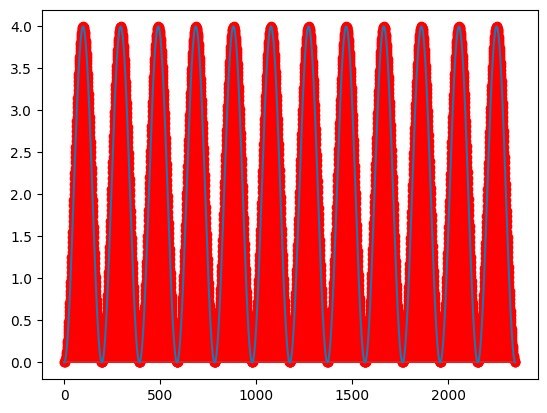

In [309]:
import matplotlib.pyplot as plt # For ploting
import numpy as np # to work with numerical data efficiently

fs = 2351 # sample rate 
f = 5 # the frequency of the signal

#x = np.arange(fs) # the points on the x axis for plotting
#print(x)
x = np.array([i for i in range(fs)])
#print(x)
# compute the value (amplitude) of the sin wave at the for each sample
#y = (1 - np.sin(0.5 * np.pi + 2*np.pi*f * ((x)/fs))) * 2 + 0
y = 1 - np.sin(0.5 * np.pi + 2*np.pi*12 * ((x)/fs)) * 2 + 1

print("jere")
print(10 * 60 * 40)

#this instruction can only be used with IPython Notbook. 
# showing the exact location of the smaples
plt.stem(x,y, 'r', )
plt.plot(x,y)
np.cos(2*np.pi*f * (10/fs)) * 1 + 2
range(int((1 - np.sin(2*np.pi*f * (50/fs))) *  + 2))


## cleanup (this is what is being used)

In [76]:
import librosa 
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from random import randint

            
t_min = 50
t_max = 600
f_time, f_frequency, f_confidence = [time[t_min:], frequency[t_min:], confidence[t_min:]]
s_confidence = savgol_filter(f_confidence, 30, 4)

def freqs_to_midi(freqs, confs):
    last_confident_value = 51
    for f, c in zip(freqs, confs):
        if c > 0.9:
            last_confident_value = librosa.hz_to_midi(f)
        yield last_confident_value

def snap_midi(midi):
    r_midi = np.around(midi)
    s_midi = np.around(savgol_filter(midi, 30, 5))
    last_val = s_midi[0]
    for i, (r1, r2) in enumerate(pairwise(r_midi)):
        if r1 != r2:
            last_val = s_midi[i+5]
        yield last_val
    yield last_val

def filter_midi(midi):

    def integrate(midi):
        print(len(midi) / 40)
        for imx, m in enumerate(midi):
            if m != midi[imx - 1] or imx == 0:
                if imx == 0:
                    ins = 2
                    val = m[2]
                    last_val = val
                else:
                    ins = [pmx for pmx, p in enumerate(m) if p != midi[imx - 1][pmx]][0]
                    val = m[ins]

                note_dur = 0
                #print(ins)
                #print(val)
                while imx + note_dur < len(midi) and midi[imx + note_dur][ins] == val:
                    note_dur += 1

                if note_dur >= 10:
                    if False:
                        yield (imx / 40.0, val, ins, None)
                    else:
                        dev = val - last_val
        
                        print (imx / 40.0, val, ins, val)
                        print(note_dur / 40.0)
                        yield (imx / 40.0, val, ins, val)
        
                        tail = randint(20, 40)
                        if note_dur / 2 > tail and ins != 2:
                        #if False:
                            t_sum = 0
                            while t_sum < tail:
                                print("here")
                                print ((imx + note_dur - tail + t_sum) / 40, val, ins, None)
                                print(note_dur / 40.0)
                                if True:
                                    yield ((imx + note_dur - tail + t_sum) / 40, val, ins, None)
                                t_sum += randint(10, 15)
                        
                        last_val = val

    def redifferentiate(sorted_midi):
        for imx, sm in enumerate(sorted_midi):
            print("---")
            print(sm)
            if imx < len(sorted_midi) - 1:
                dur = round(sorted_midi[imx + 1][0] - sm[0], 3)
            else:
                dur = 1
            [val, ins] = sm[1:-1]
            dev = 0
            if imx == 0:
                dev = 0.0
                last_val = val
            elif sm[-1] == None:
                dev = None
            else:
                dev = (sm[-1] - last_val) * 100.0
                last_val = val
            print((dur, val, ins, dev))
            yield (dur, val, ins, dev)

    #print(midi)
    sorted_midi = sorted(integrate(midi))
    #for sm in sorted_midi:
    #    print(sm)
    redifferentiated_midi = redifferentiate(sorted_midi)
    print(midi)
    return redifferentiated_midi

midi = list(freqs_to_midi(f_frequency, f_confidence))
midi = tuple(snap_midi(midi))

fs = 2351 # sample rate 
f = 20 # the frequency of the signal

#midi = zip(
#    tuple(midi[0] - 24 for i in range(4 * 40)) + tuple(chain(*tuple([m - 24 for r in range(int(1 - np.sin(2*np.pi*10 * (imx/fs))) * 3 + 1)] for imx, m in enumerate(midi)))),
#    tuple(midi[0] - 12 for i in range(2 * 40)) + tuple(chain(*tuple([m - 12 for r in range(int(1 - np.sin(2*np.pi*10 * (imx/fs))) * 3 + 1)] for imx, m in enumerate(midi)))),
#    tuple(chain(*tuple([m for r in range(int(1 - np.cos(0.5 * np.pi + 2*np.pi*10 * (imx/fs))) * 3 + 1)] for imx, m in enumerate(midi))))
#)
print(list(midi))
midi = zip(
    tuple(midi[0] - 0 for i in range(6 * 40)) + tuple(chain(*tuple([m - 0 for r in range(int(1 - np.sin(0.5 * np.pi + 2*np.pi*14 * (imx/fs))) * 3 + 1)] for imx, m in enumerate(midi)))),
    tuple(midi[0] - 0 for i in range(3 * 40)) + tuple(chain(*tuple([m - 0 for r in range(int(1 - np.sin(0.5 * np.pi + 2*np.pi*12 * (imx/fs))) * 2 + 1)] for imx, m in enumerate(midi)))),
    tuple(chain(*tuple([m for r in range(int(1 - np.cos(0.5 * np.pi + 2*np.pi*10 * (imx/fs))) * 0 + 1)] for imx, m in enumerate(midi))))
)

target_melody_data = list(filter_midi(list(midi)))
target_melody_data


[51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 53.0, 53.0, 53.0, 53.0, 53.0, 53.0, 53.0, 53.0, 53.0, 53.0, 53.0, 53.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.

[(1.05, 51.0, 2, 0.0),
 (0.3, 53.0, 2, 200.0),
 (1.5, 51.0, 2, -200.0),
 (0.425, 49.0, 2, -200.0),
 (0.775, 48.0, 2, -100.0),
 (0.2, 53.0, 1, 500.0),
 (0.35, 49.0, 2, -400.0),
 (0.375, 51.0, 1, 200.0),
 (0.675, 51.0, 2, 0.0),
 (1.15, 51.0, 2, 0.0),
 (0.25, 48.0, 2, -300.0),
 (0.725, 53.0, 0, 500.0),
 (0.325, 51.0, 2, -200.0),
 (0.15, 51.0, 1, None),
 (0.1, 51.0, 0, 0.0),
 (0.075, 51.0, 1, None),
 (0.275, 53.0, 2, 200.0),
 (0.175, 51.0, 1, None),
 (0.175, 51.0, 2, -200.0),
 (0.05, 51.0, 1, None),
 (1.275, 49.0, 1, -200.0),
 (0.1, 48.0, 1, -100.0),
 (0.4, 52.0, 2, 400.0),
 (0.575, 48.0, 2, -400.0),
 (0.325, 48.0, 1, None),
 (0.35, 48.0, 1, None),
 (0.025, 48.0, 1, None),
 (0.05, 49.0, 1, 100.0),
 (0.675, 53.0, 2, 400.0),
 (0.1, 51.0, 1, -200.0),
 (0.575, 49.0, 2, -200.0),
 (0.125, 51.0, 1, 200.0),
 (0.275, 51.0, 0, None),
 (0.275, 51.0, 0, None),
 (0.025, 51.0, 0, None),
 (0.475, 49.0, 0, -200.0),
 (0.325, 52.0, 2, 300.0),
 (0.025, 51.0, 1, None),
 (0.075, 49.0, 0, None),
 (0.175, 51.0, 

In [78]:
pip install pretty-midi

  Using cached pretty_midi-0.2.10.tar.gz (5.6 MB)
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 7.3 MB/s eta 0:00:00
  Created wheel for pretty-midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592289 sha256=a0463f41638e81a9a9b614dbeaf824e00b96bce9e004a3100eebe34e1e5d62a1
  Stored in directory: /home/mwinter/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty-midi
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: /home/mwinter/python_envs/compact_sets/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [642]:
import csv
import pretty_midi
import math
midi = []

def format_csv(file):
    with open(file) as csvfile:
        length = 500
        data = list(csv.DictReader(csvfile))[0:length]
        for dmx, val in enumerate(data[:length-1]):
            dur = float(data[dmx+1]['start_time']) - float(val['start_time'])
            #print(dur)
            for i in range(int(dur / 0.025)):
                yield(float(val['pitch']))
    for i in range(int(1 / 0.025)):
         yield(float(data[length-1]['pitch']))


def format_midifile(file):
    midi_data = pretty_midi.PrettyMIDI(file)
    ins = midi_data.instruments[0]
    notes = ins.notes;
    print(len(notes))
    for dmx, val in enumerate(notes[:len(notes)-1]):
        dur = float(notes[dmx+1].start) - float(val.start)
        #print(dur)
        for i in range(int(dur / 0.025)):
            yield(float(val.pitch))
    for i in range(int(1 / 0.025)):
         yield(float(notes[len(notes)-1].pitch))

def filter_midi(midi):

    def nearest_quarter(x):
        return round(x*4)/4
        #return math.ceil(x*4)/4

    def integrate(midi):
        #print(len(midi) / 40)
        for imx, m in enumerate(midi):
            if m != midi[imx - 1] or imx == 0:
                if imx == 0:
                    ins = 2
                    val = m[2]
                    last_val = val
                else:
                    ins = [pmx for pmx, p in enumerate(m) if p != midi[imx - 1][pmx]][0]
                    val = m[ins]

                note_dur = 0
                #print(ins)
                #print(val)
                while imx + note_dur < len(midi) and midi[imx + note_dur][ins] == val:
                    note_dur += 1

                if note_dur >= 10:
                    if False:
                        yield (imx / 40.0, val, ins, None)
                    else:
                        dev = val - last_val
        
                        #print (imx / 40.0, val, ins, val)
                        #print(note_dur / 40.0)
                        yield (imx / 40.0, val, ins, val)
        
                        tail = randint(20, 40)
                        if note_dur / 2 > tail:# and ins != 0:
                        #if False:
                            t_sum = 0
                            while t_sum < tail:
                                #print("here")
                                #print ((imx + note_dur - tail + t_sum) / 40, val, ins, None)
                                #print(note_dur / 40.0)
                                if True:
                                    yield ((imx + note_dur - tail + t_sum) / 40, val, ins, None)
                                t_sum += randint(10, 15)
                        
                        last_val = val
                #else:
                #    yield (10 / 40.0, val, ins, val)

    def redifferentiate(sorted_midi):
        for imx, sm in enumerate(sorted_midi):
            #print("---")
            #print(sm)
            if imx < len(sorted_midi) - 1:
                #dur = round(sorted_midi[imx + 1][0] - sm[0], 3)
                dur = max([0.25, nearest_quarter(sorted_midi[imx + 1][0] - sm[0])])
                #dur = nearest_quarter(sorted_midi[imx + 1][0] - sm[0])
            else:
                dur = 1
            [val, ins] = sm[1:-1]
            dev = 0
            if imx == 0:
                dev = 0.0
                last_val = val
            elif sm[-1] == None:
                dev = None
            else:
                dev = (sm[-1] - last_val) * 100.0
                last_val = val
            #print((dur, val, ins, dev))
            if(dur == 0):
                print((dur, val, ins, dev))
            yield (dur, val, ins, dev)

    #print(midi)
    sorted_midi = sorted(integrate(midi))
    #for sm in sorted_midi:
    #    print(sm)
    redifferentiated_midi = redifferentiate(sorted_midi)
    #print(midi)
    return redifferentiated_midi

#midi = list(format_csv('bereshit_chant_f0.csv'))
midi = list(format_midifile('bereshit_chant.mid')) #definitely better with this
print(len(midi))
print(midi)

osc = 20000
midi = zip(
    tuple(midi[0] - 0 for i in range(6 * 40)) + tuple(chain(*tuple([m - 0 for r in range(int(1 - np.sin(0.5 * np.pi + 2*np.pi*10 * (imx/osc))) * 4 + 1)] for imx, m in enumerate(midi)))),
    tuple(midi[0] - 0 for i in range(3 * 40)) + tuple(chain(*tuple([m - 0 for r in range(int(1 - np.sin(0.5 * np.pi + 2*np.pi*10 * (imx/osc))) * 1 + 1)] for imx, m in enumerate(midi)))),
    tuple(chain(*tuple([m for r in range(int(1 - np.cos(0.5 * np.pi + 2*np.pi*16 * (imx/osc))) * 0 + 1)] for imx, m in enumerate(midi))))
)

target_melody_data = list(filter_midi(list(midi)))
target_melody_data

1150
23206
[51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 49.0, 49.0, 49.0

[(2.0, 51.0, 2, 0.0),
 (0.25, 51.0, 2, None),
 (0.25, 51.0, 2, None),
 (0.25, 51.0, 2, None),
 (0.5, 49.0, 2, -200.0),
 (1.0, 48.0, 2, -100.0),
 (0.75, 49.0, 2, 100.0),
 (1.0, 51.0, 2, 200.0),
 (0.25, 49.0, 1, -200.0),
 (0.5, 51.0, 2, None),
 (0.25, 51.0, 2, None),
 (0.25, 48.0, 1, -100.0),
 (0.25, 51.0, 2, None),
 (0.5, 48.0, 2, 0.0),
 (0.5, 49.0, 1, 100.0),
 (0.25, 51.0, 2, 200.0),
 (0.5, 51.0, 1, 0.0),
 (0.5, 53.0, 2, 200.0),
 (0.25, 49.0, 0, -400.0),
 (0.25, 51.0, 1, None),
 (0.25, 51.0, 1, None),
 (0.25, 48.0, 0, -100.0),
 (0.25, 51.0, 1, None),
 (0.5, 48.0, 1, 0.0),
 (0.5, 49.0, 0, 100.0),
 (0.25, 51.0, 1, 200.0),
 (0.25, 48.0, 2, -300.0),
 (0.5, 51.0, 0, 300.0),
 (0.25, 53.0, 1, 200.0),
 (0.25, 44.0, 2, -900.0),
 (0.25, 51.0, 1, 700.0),
 (0.25, 53.0, 2, 200.0),
 (0.25, 51.0, 0, None),
 (0.25, 51.0, 0, None),
 (0.25, 49.0, 2, -400.0),
 (1.0, 48.0, 0, -100.0),
 (0.25, 51.0, 0, 300.0),
 (0.5, 48.0, 1, -300.0),
 (0.25, 52.0, 2, 400.0),
 (0.25, 53.0, 0, 100.0),
 (0.25, 44.0, 1, -900.

In [643]:
seed(19541116)
factors = []
dims = (2, 3, 5, 7)
root = (0, 0, 0, 0)
start_chord = ((-2, 1, 0, 0), (0, 0, 0, 0), (-3, 2, 0, 0))
path = stochastic_hamiltonian(start_chord)
#durs = tuple(round(y[0]-x[0], 2) for (x, y) in pairwise(target_melody_data)) + ((1,))
durs = tuple(d[0] for d in target_melody_data)
#path_to_chords(path, root)
write_chord_sequence(list(zip(durs, path_to_chords(path, root))), "breysheet.txt")

[-701.9550008653874, -203.91000173077484, 0]
2
None
(2, 0, 0, 0)
(2, -2, 0, 0)
(2, -1, 1, 0)
(2, -1, -1, 0)
(2, -1, 0, 1)
(2, -1, 0, -1)
(0, 1, 0, 0)
(0, -1, 0, 0)
(0, 0, 1, 0)
(0, 0, -1, 0)
(0, 0, 0, 1)
(0, 0, 0, -1)
here
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
[-701.9550008653874, -203.91000173077484, 0]
((-2, 1, 0, 0), (0, 0, 0, 0), (-3, 2, 0, 0))
((-2, 1, 0, 0), (0, 0, 0, 0), (-2, 0, 1, 0))
[-701.9550008653874, -203.91000173077484, 182.40371213406]
[-498.04499913461257, 0.0, 203.91000173077484]
[-498.04499913461257, 0.0, 386.3137138648348]
2
None
(2, 0, 0, 0)
(2, -2, 0, 0)
(2, -1, 1, 0)
(2, -1, -1, 0)
(2, -1, 0, 1)
(2, -1, 0, -1)
(0, 1, 0, 0)
(0, -1, 0, 0)
(0, 0, 1, 0)
(0, 0, -1, 0)
(0, 0, 0, 1)
(0, 0, 0, -1)
here
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
[-701.9550008653874, -203.91000173077484, 182.40371213406]
((-2, 1, 0, 0), (0, 0, 0, 0), (-2, 0, 1, 0))
((-

## function-based approach

### path functions

#### legacy

In [15]:
from random import choice, choices

def hd_sum(chord):
    distances = []
    size = len(chord)
    for i in range(size):
        for j in range(i+1, size):
            distances += [sum([abs(dist) * log(dims[idx], 2) for idx, dist in enumerate(pitch_difference(chord[i], chord[j]))])]
    return sum(distances)
    
def next_edges(source, last_chords):  

    def transpose_to_nearest(hs_array1, hs_array2):
        expanded_pitch = hs_array2
        frequency_ratio = hs_array_to_fr(list(hs_array2)) / hs_array_to_fr(list(hs_array1))
        if frequency_ratio < 1:
            while frequency_ratio < 1:
                frequency_ratio *= 2
                expanded_pitch[0] += 1
        elif frequency_ratio >= 2:
            while frequency_ratio >= 2:
                frequency_ratio *= 1/2
                expanded_pitch[0] += -1
        return tuple(expanded_pitch)
        
    def gen_candidates(chord, last_chords):
        for sdx, s_pitch in enumerate(chord):
            for cdx, c_pitch in enumerate(chord):
                if cdx != sdx:   
                    for ddx, dim in enumerate(c_pitch[1:]):
                        for alt in [-1, 1]:
                            new_pitch = list(c_pitch)
                            new_pitch[ddx+1] += alt
                            new_pitch_up = transpose_to_nearest(s_pitch, new_pitch)
                            new_chord_up = list(chord)
                            new_chord_up[sdx] = tuple(new_pitch_up)
                            #print("here")
                            #print(new_pitch_up)
                            #print(tuple(l[sdx] for l in last_chords))
                            #print(new_pitch_up not in tuple(l[sdx] for l in last_chords))
                            
                            #if tuple(new_chord_up) != chord and (tuple(new_pitch_up) not in tuple(l[sdx] for l in last_chords)) and max(new_pitch_up[1:]) <= 1 and min(new_pitch_up[1:]) >= 0 and sum(new_pitch_up[1:]) <= 2:
                            if tuple(new_chord_up) != chord and max(new_pitch_up[1:]) <= 1 and min(new_pitch_up[1:]) >= 0 and sum(new_pitch_up[1:]) <= 2:
                            #if tuple(new_chord_up) != chord and tuple(new_pitch_up) not in tuple(l[sdx] for l in last_chords):
                            #if tuple(new_chord_up) != chord:
                                yield tuple(new_chord_up)

                            new_pitch_down = list(new_pitch_up)
                            new_pitch_down[0] += -1
                            new_chord_down = list(chord)
                            new_chord_down[sdx] = tuple(new_pitch_down)

                            #print("here2")
                            #print(new_pitch_down)
                            #print(tuple(l[sdx] for l in last_chords))
                            #print(new_pitch_down not in tuple(l[sdx] for l in last_chords))
                            #if tuple(new_chord_down) != chord:
                            #if tuple(new_chord_down) != chord and new_pitch_down not in tuple(l[sdx] for l in last_chords):
                            if tuple(new_chord_down) != chord and max(new_pitch_down[1:]) <= 1 and min(new_pitch_down[1:]) >= 0 and sum(new_pitch_up[1:]) <= 2:
                            #if tuple(new_chord_down) != chord and (tuple(new_pitch_down) not in tuple(l[sdx] for l in last_chords)) and max(new_pitch_down[1:]) <= 1 and min(new_pitch_down[1:]) >= 0 and sum(new_pitch_up[1:]) <= 2:
                                yield tuple(new_chord_down)

    for candidate in gen_candidates(source, last_chords):

        movements = {
            pitch:
            {
                'destination': candidate[index], 
                'cent_difference': cent_difference(pitch, candidate[index])
            } for index, pitch in enumerate(source)}
        
        yield (tuple(source), tuple(candidate), {'transposition': root, 'movements': movements},)


# This is for the beginning / breysheet - redone to calculate next chord as a function and not from the graph
def stochastic_hamiltonian(root):

    #try making this omit the moving voice
    def movement_size_weights(edges):
        
        def max_cent_diff(edge):
            res = max([abs(v) for val in edge[2]['movements'].values() if (v:=val['cent_difference']) is not None])
            return res
            
        def min_cent_diff(edge):
            res = [abs(v) for val in edge[2]['movements'].values()  if (v:=val['cent_difference']) is not None]
            res.remove(0)
            return min(res)
            
        for e in edges:
            yield 100 if ((max_cent_diff(e) < 200) and (min_cent_diff(e)) >= 50) else 1/pow(1.1, max_cent_diff(e))

    def hamiltonian_weights(edges):
        for e in edges:
            yield 10 if e[1] not in [path_edge[0] for path_edge in path] else 1 / graph.nodes[e[1]]['count']
    
    def contrary_motion_weights(edges):

        def is_contrary(edge):
            cent_diffs = [v for val in edge[2]['movements'].values() if (v:=val['cent_difference']) is not None]
            cent_diffs.sort()
            return (cent_diffs[0] < 0) and (cent_diffs[1] == 0) and (cent_diffs[2] > 0)

        for e in edges:
            yield 2 if is_contrary(e) else 1
    
    def is_directly_tunable_weights(edges):
        for e in edges:
            yield 10 if e[2]['is_directly_tunable'] else 1

    def symdiff_weights(edges):
        for e in edges:
            yield 1000 if e[2]['symmetric_difference'] == 2 else 1

    def transposition_weight(edges):
        for e in edges:
            yield 100 if 0 <= hs_array_to_cents(e[2]['transposition']) < 100 else 1

    def in_range(edges):
        for e in edges:
            s_chord = sorted(e[1], key=hs_array_to_fr)
            yield 5 if hs_array_to_fr(sorted(e[1], key=hs_array_to_fr)[0]) >= 0.25 else 0

    def hd_weight(edges):
        for e in edges:
            yield 100 * (1/pow(hd_sum(e[1]), 2))

    def permission_weight(edges, allowed_ins):
        print("here")
        print(allowed_ins)
        print("---")
        for e in edges:
            diff = [ibx for ibx, pitch in enumerate(e[0]) if pitch != e[1][ibx]][0]
            yield 1 if diff in allowed_ins else 0

    def dca_weight(edges, ins, last_chords):
        for e in edges:
            #print(tuple(e[1][ins]))
            #print(ins)
            #print(tuple(l[ins] for l in last_chords))
            diff_e = [i for i, item in enumerate(e[0]) if item != e[1][i]][0]
            if ins == diff_e:
                yield 1
            else:
                yield 100 if tuple(e[1][diff_e]) not in tuple(l[diff_e] for l in last_chords) else 0

    def is_sustained_voice(edges, voice):
        
        def is_sustained(edge):
            source = list(edge[0])
            ordered_source = sorted(source, key=hs_array_to_fr)    
            destination = [transpose_pitch(edge[2]['movements'][p]['destination'], edge[2]['transposition']) for p in source]
            ordered_destination = sorted(destination, key=hs_array_to_fr)
            return ordered_source[voice] == ordered_destination[voice]

        for e in edges:
            yield 10 if is_sustained(e) else 1

    def favor_bass(edges, ins):

        def ins_check(edge, ins):
            source = list(edge[0])
            ordered_source = sorted(source, key=hs_array_to_fr)    
            destination = [transpose_pitch(edge[2]['movements'][p]['destination'], edge[2]['transposition']) for p in source]
            ordered_destination = sorted(destination, key=hs_array_to_fr)
            if ins == 2:
                return 1
            elif ins == 1 and ordered_source[0] != ordered_destination[0]:
                return 1
            else:
                return 0

        for e in edges:
            yield ins_check(e, ins)

    def voice_crossing_weights(edges):
        
        def has_voice_crossing(edge):
            source = list(edge[0])
            ordered_source = sorted(source, key=hs_array_to_fr)    
            source_order = [ordered_source.index(p) for p in source]
            destination = [transpose_pitch(edge[2]['movements'][p]['destination'], edge[2]['transposition']) for p in source]
            ordered_destination = sorted(destination, key=hs_array_to_fr)
            destination_order = [ordered_destination.index(p) for p in destination]
            return source_order != destination_order

        for e in edges:
            yield 10 if not has_voice_crossing(e) else 0

    def is_bass_rooted(chord):
        return max([sum(abs(p) for p in collapse_pitch(pitch_difference(chord[0], p))) for p in chord[1:]]) == 1

    def target_melody_weights(edges, target, c_devs, voice):

        def target_weight(edge, target, c_devs, voice):
            candidate_diffs = []
            for idx, dev in enumerate(c_devs):
                if(idx == voice):
                    source = list(edge[0])
                    ordered_source = sorted(source, key=hs_array_to_fr)    
                    candidate_diff = edge[2]['movements'][ordered_source[idx]]['cent_difference']
                    candidate_diffs += [abs(dev + candidate_diff - target)]
            #return 1/pow(1.1, min(candidate_diffs))
            return 100 if min(candidate_diffs) < 40 else 1/pow(1.1, min(candidate_diffs))
            
        for e in edges:
            yield target_weight(e, target, c_devs, voice)
        
    #check_graph = graph.copy()
    #next_node = choice(list(graph.nodes()))
    next_node = ((-2, 0, 0, 0, 0, 0), (-1, 0, 0, 0, 0, 0), (-3, 0, 0, 0, 1, 0))
    #check_graph.remove_node(next_node)
    #for node in graph.nodes(data=True):
    #    node[1]['count'] = 1
    path = []
    s_next_node = sorted(next_node, key=hs_array_to_fr)
    last_chords = (tuple(s_next_node),)
    c_devs = (cent_difference(s_next_node[2], s_next_node[0]), cent_difference(s_next_node[2], s_next_node[1]), 0,)
    #c_devs = (0, cent_difference(s_next_node[0], s_next_node[1]), cent_difference(s_next_node[0], s_next_node[2]),)
    print(c_devs)
    #while (nx.number_of_nodes(check_graph) > 0) and (len(path) < len(target_melody_data)-1):
    while (len(path) < len(target_melody_data)-1):
        #out_edges = list(graph.out_edges(next_node, data=True))
        out_edges = list(next_edges(next_node, last_chords))
        target = target_melody_data[len(path)+1][-1]
        ins = target_melody_data[len(path)+1][2]
        print(target)
        print(ins)
        factors = [
            movement_size_weights(out_edges), 
            #hamiltonian_weights(out_edges), 
            #contrary_motion_weights(out_edges), 
            #is_directly_tunable_weights(out_edges),
            voice_crossing_weights(out_edges),
            #transposition_weight(out_edges),
            #is_sustained_voice(out_edges, 0),
            target_melody_weights(out_edges, target, c_devs, ins),
            #symdiff_weights(out_edges),
            hd_weight(out_edges),
            dca_weight(out_edges, ins, last_chords),
            permission_weight(out_edges, target_melody_data[len(path)+1][3])
            #favor_bass(out_edges, ins),
            #in_range(out_edges)
        ]
        weights = [prod(a) for a in zip(*factors)]
        if sum(weights) != 0:
            edge = choices(out_edges, weights=weights)[0]
        else:
            movements = {
                pitch:
                    {
                        'destination': pitch, 
                        'cent_difference': 0
                    } for index, pitch in enumerate(edge[1])}
            edge = (edge[1], edge[1], {'transposition': (0, 0, 0, 0, 0, 0), 'movements': movements},)
        
        next_node = edge[1]
        last_chords = last_chords + (next_node,)
        if len(last_chords) > 10:
            last_chords = last_chords[-10:]
        print(last_chords)
        #node[1]['count'] += 1
        path.append(edge)
        s_chord = tuple(sorted(edge[0], key=hs_array_to_fr))
        print(c_devs)
        #for pdx, pitch in enumerate(s_chord):
        #    print("here")
        #    print(c_devs[pdx])
        #    print(edge[2]['movements'][pitch]['cent_difference'])
        #    print(target_melody_data[len(path)][-1])
        if sum(weights) != 0:
            c_devs = tuple(c_devs[pdx] + edge[2]['movements'][pitch]['cent_difference'] - target_melody_data[len(path)][-1] for pdx, pitch in enumerate(s_chord))
        print(s_chord)
        print(edge[1])
        print(c_devs)
        print(target_melody_data[len(path)][2])
        print(target_melody_data[len(path)][-1])
        #if next_node in check_graph.nodes:
        #    check_graph.remove_node(next_node)
    return path

#### cleanup (this is what is being used)

In [656]:
from random import choice, choices

def path_to_chords(path, start_root):
    current_root = start_root
    start_chord = tuple(sorted(path[0][0], key=hs_array_to_fr))
    chords = (start_chord,)
    for edge in path:
        chords += (edge[1],)
    return chords
    
def next_edges(source, ins, dev_target):  

    def transpose_to_nearest(hs_array1, hs_array2):
        expanded_pitch = hs_array2
        frequency_ratio = hs_array_to_fr(list(hs_array2)) / hs_array_to_fr(list(hs_array1))
        if frequency_ratio < 1:
            while frequency_ratio < 1:
                frequency_ratio *= 2
                expanded_pitch[0] += 1
        elif frequency_ratio >= 2:
            while frequency_ratio >= 2:
                frequency_ratio *= 1/2
                expanded_pitch[0] += -1
        return tuple(expanded_pitch)


    def gen_candidates(chord, ins, dev_target):
        sustain = ((0, 0, 0, 0), (-1, 1, 0, 0)) #, (-1, 0, 1, 0), (-2, 0, 0, 1))
        refs = chord
        #if ins == 2:
        refs += sustain
        #if ins != 2:
        #    sustain = sustain + (chord[2],)
        for cdx, c_pitch in enumerate(chord):
            if cdx != ins: 
            #if True:
                enumerator = c_pitch[1:] # if dev_target != None else c_pitch[1:-1]
                for ddx, dim in enumerate(enumerator):
                    alts = [-1, 1] #if dev_target != None else [1]
                    #alts = [-1, 1] if choices([True, False], weights=[1, 3]) else [1]
                    for alt in alts:
                        new_pitch = list(c_pitch)
                        new_pitch[ddx+1] += alt
                        print(pitch_difference(sustain[0], new_pitch))
                        
                        s_pitch = chord[ins]
                        new_pitch = transpose_to_nearest(s_pitch, new_pitch)
                        for octave in range(-1, 2):
                    
                            f_new_pitch = list(new_pitch)
                            f_new_pitch[0] += octave
                            f_chord = list(chord)
                            f_chord[ins] = tuple(f_new_pitch)

                            limit_test_vals = [v for d in list(zip(*f_chord))[1:] for v in d]
                            sum_test_vals = [sum(p[1:]) for p in f_chord]
                            if tuple(f_chord) != chord and chord and max(limit_test_vals) <= 2 and min(limit_test_vals) >= -1 and max(sum_test_vals) <= 3:
                                if tuple(f_chord) != chord and max([abs(hs_array_to_cents(tp)) for tp in f_chord]) < 1200: # and len(set(f_chord)) == 3:
                                    #print(f_chord)
                                    yield tuple(f_chord)
                                
    for candidate in gen_candidates(source, ins, dev_target):
        yield (tuple(source), tuple(candidate), tuple(cent_difference(pitch, candidate[index]) for index, pitch in enumerate(source)))

def hd_sum(chord):
    distances = []
    size = len(chord)
    for i in range(size):
        for j in range(i+1, size):
            distances += [sum([abs(dist) * log(dims[1:][idx], 2) for idx, dist in enumerate(pitch_difference(chord[i][1:], chord[j][1:]))])]
    return sum(distances)

# This is for the beginning / breysheet - redone to calculate next chord as a function and not from the graph
def stochastic_hamiltonian(start_chord):

    def movement_size_weights(edges, ins):
        
        def cent_diff(edge):
            return abs(edge[2][ins])
            
        for e in edges:
            yield 100 if (cent_diff(e) < 250) and (cent_diff(e) >= 50) else 1/pow(cent_diff(e), 1)

    def in_range(edges):
        for e in edges:
            s_chord = sorted(e[1], key=hs_array_to_fr)
            yield 1 if hs_array_to_fr(sorted(e[1], key=hs_array_to_fr)[0]) >= 0.25 else 0

    def hd_weight(edges):
        for e in edges:
            cand_hd_sum = hd_sum(e[1])
            yield (1/pow(cand_hd_sum, 1)) if cand_hd_sum > 0 else 0

    def dca_weight(edges, ins, dev, last_chords):
        for e in edges:
            if False:
                yield 1
            else:
                yield 5 if tuple(e[1][ins]) not in tuple(l[ins] for l in last_chords) else 0
                #yield 5 if tuple(e[1][ins][1:]) not in tuple(p[1:] for chord in last_chords for p in chord) else 0

    def voice_crossing_weights(edges):
        
        def has_voice_crossing(edge):
            source = list(edge[0])
            ordered_source = sorted(source, key=hs_array_to_fr)    
            source_order = [ordered_source.index(p) for p in source]
            destination = list(edge[1])
            ordered_destination = sorted(destination, key=hs_array_to_fr)
            destination_order = [ordered_destination.index(p) for p in destination]
            return source_order != destination_order

        for e in edges:
            yield 1 if not has_voice_crossing(e) else 0

    def normalize_sum(array):
        if sum(array) != 0:
            return [val / sum(array) for val in array]
        else:
            return [0 for val in array]

    def normalize(array):
        if len(set(array)) > 1:
            max_value = max(array)
            min_value = min(array)
            return [(((val - min_value) / (max_value - min_value)) * 0.9 + 0.1) for val in array]
        else:
            return [1 for val in array]

    def registration_weights(edges):

        def reg_min(edge):
            # confusing naming convention I know
            collapsed_chord = expand_chord(edge[1])
            return min(hs_array_to_cents(pair[1]) - hs_array_to_cents(pair[0]) for pair in pairwise(sorted(collapsed_chord, key=hs_array_to_cents)))

        return [10 if reg_min(e) > 270 else 1 for e in edges]

    def target_melody_weights(edges, target_dev, c_devs, ins):

        def candidate_diff(edge, target_dev, c_devs, ins): 
            if target_dev != None:
                return abs(c_devs[ins] + edge[2][ins] - target_dev)
            else:
                return 1

        if target_dev != None:
            #for edge in edges:
            #    print(edge[1])
            #    print(candidate_diff(edge, target_dev, c_devs, ins))
            diffs = [candidate_diff(edge, target_dev, c_devs, ins) for edge in edges]
            min_diff = min(diffs)
            #print([1 if diff == min_diff else 0 for diff in diffs])
            return [1 if diff == min_diff else 0 for diff in diffs]
        else:
            return [1 for edge in edges]


    def harmonic_contraint_weight(edges, ins):

        def within_contraint(edge, ins):
            sustain = ((0, 0, 0, 0), (-1, 1, 0, 0))
            print(sum([abs(diff) for diff in pitch_difference(sustain[0][1:], edge[1][ins][1:])]) <= 1 or sum([abs(diff) for diff in pitch_difference(sustain[1][1:], edge[1][ins][1:])]) <= 1)
            return sum([abs(diff) for diff in pitch_difference(sustain[0][1:], edge[1][ins][1:])]) <= 1 or sum([abs(diff) for diff in pitch_difference(sustain[1][1:], edge[1][ins][1:])]) <= 1

        for e in edges:
            yield 10 if within_contraint(e, ins) else 1
            
    next_node = start_chord
    path = []
    s_next_node = sorted(next_node, key=hs_array_to_fr)
    last_chords = (tuple(s_next_node),)
    unison = tuple(0 for p in start_chord[0])
    c_devs = [cent_difference(s_next_node[2], s_next_node[0]), cent_difference(s_next_node[2], s_next_node[1]), 0]
    #c_devs = (0, cent_difference(s_next_node[0], s_next_node[1]), cent_difference(s_next_node[0], s_next_node[2]),)
    print(c_devs)
    for dur, val, ins, dev in target_melody_data[1:]:
        print(ins)
        print(dev)
        out_edges = list(next_edges(next_node, ins, dev))
        print("here")
        #print(list(target_melody_weights(out_edges, dev, c_devs, ins)))
        #print(max(list(target_melody_weights(out_edges, dev, c_devs, ins))))
        factors = [
            list(movement_size_weights(out_edges, ins)), 
            list(voice_crossing_weights(out_edges)),
            list(target_melody_weights(out_edges, dev, c_devs, ins)),
            list(hd_weight(out_edges)),
            list(dca_weight(out_edges, ins, dev, last_chords)),
            list(registration_weights(out_edges)),
            list(harmonic_contraint_weight(out_edges, ins))
        ]
        weights = [100, 0, 10, 10000, 100, 1000, 1000]
        #if (ins == 2 and dev != None) or (ins != 2 and dev != None and choices([True, False], weights=[1,1])[0]):
        if ins == 2: 
            skip_weights = [2, 1]
        elif ins == 1:
            skip_weights = [2, 1]
        else:
            skip_weights = [2, 1]
        if (dev != None and choices([True, False], weights=skip_weights)[0]):
            weights[0] = 0
            weights[3] = 0
            weights[4] = 0
            #weights[5] = 0
        else:
            weights[2] = 0

        if dev == None:
            weights[2] = 0
        #print(factors)
        candidate_exists = sum([prod(a) for a in zip(*factors)]) != 0
        candidate_exists = True
        #print("here")
        #print(factors)
        if candidate_exists: # and not (ins == 2 and dev == None):
            #norm_weights = [prod(a) for a in zip(*[[(f / sum(factor)) * weights[ifx] if f != 0 else 0 for f in list(factor)] for ifx, factor in enumerate(factors) if weights[ifx] != 0])]
            if False:
                norm_weights = target_melody_weights(out_edges, dev, c_devs, ins)
            else:
                norm_weights = [prod(a) for a in zip(*[[nf * weights[ifx] for nf in list(factor)] for ifx, factor in enumerate(factors) if weights[ifx] != 0])]
            #print(max(norm_weights))
            #print(norm_weights)
            edge = choices(out_edges, weights=norm_weights)[0]
        else:
            edge = (next_node, next_node, (0, 0, 0,))

        #if (ins == 0 or ins == 2) and dev == None:
        #     edge = (next_node, next_node, (0, 0, 0,))
        
        next_node = edge[1]
        last_chords = last_chords + (next_node,)
        if len(last_chords) > 10:
            last_chords = last_chords[-10:]
            print(last_chords)
        path.append(edge)
        #s_chord = tuple(sorted(edge[0], key=hs_array_to_fr))
        s_chord = edge[0]
        print(c_devs)
        if candidate_exists:
            if dev != None:
                c_devs = [c_devs[pdx] + edge[2][pdx] - dev for pdx, pitch in enumerate(s_chord)]
            else:
                c_devs[ins] += edge[2][ins]
        print(s_chord)
        print(edge[1])
        print(c_devs)
        print([hs_array_to_cents(pitch) for pitch in edge[0]])
        print([hs_array_to_cents(pitch) for pitch in edge[1]])
    return path

### model

In [657]:
seed(19541116)
factors = []
dims = (2, 3, 5, 7)
root = (0, 0, 0, 0)
start_chord = ((-2, 1, 0, 0), (0, 0, 0, 0), (-3, 2, 0, 0))
path = stochastic_hamiltonian(start_chord)
#durs = tuple(round(y[0]-x[0], 2) for (x, y) in pairwise(target_melody_data)) + ((1,))
durs = tuple(d[0] for d in target_melody_data)
#path_to_chords(path, root)
write_chord_sequence(list(zip(durs, path_to_chords(path, root))), "breysheet.txt")

[-701.9550008653874, -203.91000173077484, 0]
2
None
(2, 0, 0, 0)
(2, -2, 0, 0)
(2, -1, 1, 0)
(2, -1, -1, 0)
(2, -1, 0, 1)
(2, -1, 0, -1)
(0, 1, 0, 0)
(0, -1, 0, 0)
(0, 0, 1, 0)
(0, 0, -1, 0)
(0, 0, 0, 1)
(0, 0, 0, -1)
here
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
[-701.9550008653874, -203.91000173077484, 0]
((-2, 1, 0, 0), (0, 0, 0, 0), (-3, 2, 0, 0))
((-2, 1, 0, 0), (0, 0, 0, 0), (-2, 0, 1, 0))
[-701.9550008653874, -203.91000173077484, 182.40371213406]
[-498.04499913461257, 0.0, 203.91000173077484]
[-498.04499913461257, 0.0, 386.3137138648348]
2
None
(2, 0, 0, 0)
(2, -2, 0, 0)
(2, -1, 1, 0)
(2, -1, -1, 0)
(2, -1, 0, 1)
(2, -1, 0, -1)
(0, 1, 0, 0)
(0, -1, 0, 0)
(0, 0, 1, 0)
(0, 0, -1, 0)
(0, 0, 0, 1)
(0, 0, 0, -1)
here
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
[-701.9550008653874, -203.91000173077484, 182.40371213406]
((-2, 1, 0, 0), (0, 0, 0, 0), (-2, 0, 1, 0))
((-

In [222]:
for d in durs:
    if d == 0:
        print(d)

## graph based approach

### path functions

In [379]:
from random import choice, choices

# This is for the beginning / breysheet
def stochastic_hamiltonian(graph):

    #try making this omit the moving voice
    def movement_size_weights(edges):
        
        def max_cent_diff(edge):
            res = max([abs(v) for val in edge[2]['movements'].values() if (v:=val['cent_difference']) is not None])
            return res
            
        def min_cent_diff(edge):
            res = [abs(v) for val in edge[2]['movements'].values() if (v:=val['cent_difference']) is not None]
            res.remove(0)
            return min(res)
            
        for e in edges:
            yield 4 if ((max_cent_diff(e) < 300) and (min_cent_diff(e)) >= 0) else 1

    def hamiltonian_weights(edges):
        for e in edges:
            yield 10 if e[1] not in [path_edge[0] for path_edge in path] else 1 / graph.nodes[e[1]]['count']
    
    def contrary_motion_weights(edges):

        def is_contrary(edge):
            cent_diffs = [v for val in edge[2]['movements'].values() if (v:=val['cent_difference']) is not None]
            cent_diffs.sort()
            return (cent_diffs[0] < 0) and (cent_diffs[1] == 0) and (cent_diffs[2] > 0)

        for e in edges:
            yield 2 if is_contrary(e) else 1
    
    def is_directly_tunable_weights(edges):
        for e in edges:
            yield 10 if e[2]['is_directly_tunable'] else 1

    def symdiff_weights(edges):
        for e in edges:
            yield 1000 if e[2]['symmetric_difference'] == 2 else 1

    def transposition_weight(edges):
        for e in edges:
            yield 100 if 0 <= hs_array_to_cents(e[2]['transposition']) < 100 else 1

    def is_sustained_voice(edges, voice):
        
        def is_sustained(edge):
            source = list(edge[0])
            ordered_source = sorted(source, key=hs_array_to_fr)    
            destination = [transpose_pitch(edge[2]['movements'][p]['destination'], edge[2]['transposition']) for p in source]
            ordered_destination = sorted(destination, key=hs_array_to_fr)
            return ordered_source[voice] == ordered_destination[voice]

        for e in edges:
            yield 10 if is_sustained(e) else 1

    def voice_crossing_weights(edges):
        
        def has_voice_crossing(edge):
            source = list(edge[0])
            ordered_source = sorted(source, key=hs_array_to_fr)    
            source_order = [ordered_source.index(p) for p in source]
            destination = [transpose_pitch(edge[2]['movements'][p]['destination'], edge[2]['transposition']) for p in source]
            ordered_destination = sorted(destination, key=hs_array_to_fr)
            destination_order = [ordered_destination.index(p) for p in destination]
            return source_order != destination_order

        for e in edges:
            yield 10 if not has_voice_crossing(e) else 0

    def is_bass_rooted(chord):
        return max([sum(abs(p) for p in collapse_pitch(pitch_difference(chord[0], p))) for p in chord[1:]]) == 1

    def target_melody_weights(edges, target, c_devs, voice):

        def target_weight(edge, target, c_devs, voice):
            candidate_diffs = []
            for idx, dev in enumerate(c_devs):
                if(idx == voice):
                    source = list(edge[0])
                    ordered_source = sorted(source, key=hs_array_to_fr)    
                    candidate_diff = edge[2]['movements'][ordered_source[idx]]['cent_difference']
                    candidate_diffs += [abs(dev + candidate_diff - target)]
            #return 1/pow(1.1, min(candidate_diffs))
            return 10 if min(candidate_diffs) < 40 else 1/pow(1.1, min(candidate_diffs))
            
        for e in edges:
            yield target_weight(e, target, c_devs, voice)
        
    check_graph = graph.copy()
    next_node = choice(list(graph.nodes()))
    check_graph.remove_node(next_node)
    for node in graph.nodes(data=True):
        node[1]['count'] = 1
    path = []
    s_next_node = sorted(next_node, key=hs_array_to_fr)
    c_devs = (cent_difference(s_next_node[2], s_next_node[0]), cent_difference(s_next_node[2], s_next_node[1]), 0,)
    #c_devs = (0, cent_difference(s_next_node[0], s_next_node[1]), cent_difference(s_next_node[0], s_next_node[2]),)
    print(c_devs)
    while (nx.number_of_nodes(check_graph) > 0) and (len(path) < len(target_melody_data)-1):
        out_edges = list(graph.out_edges(next_node, data=True))
        factors = [
            movement_size_weights(out_edges), 
            #hamiltonian_weights(out_edges), 
            #contrary_motion_weights(out_edges), 
            #is_directly_tunable_weights(out_edges),
            voice_crossing_weights(out_edges),
            #transposition_weight(out_edges),
            #is_sustained_voice(out_edges, 0),
            target_melody_weights(out_edges, target_melody_data[len(path)+1][-1], c_devs, 2),
            #symdiff_weights(out_edges)
        ]
        weights = [prod(a) for a in zip(*factors)]
        edge = choices(out_edges, weights=weights)[0]
        next_node = edge[1]
        node[1]['count'] += 1
        path.append(edge)
        s_chord = tuple(sorted(edge[0], key=hs_array_to_fr))
        c_devs = tuple(c_devs[pdx] + edge[2]['movements'][pitch]['cent_difference'] - target_melody_data[len(path)][-1] for pdx, pitch in enumerate(s_chord))
        print(s_chord)
        print(c_devs)
        print(target_melody_data[len(path)][-1])
        if next_node in check_graph.nodes:
            check_graph.remove_node(next_node)
    return path

### model

In [374]:
dims = (2, 3, 5, 7)
root = (0, 0, 0, 0)
chord = (root,)
chord_set = chords(chord, root, 3, 3)
graph = generate_graph(chord_set, 2, 2, 3)

In [380]:
path = stochastic_hamiltonian(graph)
#durs = tuple(round(y[0]-x[0], 2) for (x, y) in pairwise(target_melody_data)) + ((1,))
durs = tuple(d[0] for d in target_melody_data)
path_to_chords(path, root)
print(durs)
write_chord_sequence(list(zip(durs, path_to_chords(path, root))))

(-701.9550008653874, -386.31371386483454, 0)
((0, 0, 0, 0), (1, 1, -1, 0), (-1, 1, 0, 0))
(-901.9550008653874, -586.3137138648345, -88.26871473022209)
200.0
((0, 0, 0, 0), (1, 1, -1, 0), (3, 0, -1, 0))
(-701.9550008653874, -386.31371386483454, 0.0)
-200.0
((0, 0, 0, 0), (1, 1, -1, 0), (-1, 1, 0, 0))
(-313.68628613516523, 113.68628613516546, 500.0)
-500.0
((0, 0, 0, 0), (5, 0, -2, 0), (3, 0, -1, 0))
(-184.35871299944722, 313.68628613516546, 700.0)
-200.0
((0, 0, 0, 0), (2, -1, 0, 0), (0, -1, 1, 0))
(-684.3587129994472, -186.31371386483454, 17.5962878659401)
500.0
((0, 0, 0, 0), (2, -1, 0, 0), (-1, 1, 0, 0))
(-584.3587129994472, -268.7174259988941, 117.5962878659401)
-100.0
((0, 0, 0, 0), (1, 1, -1, 0), (-1, 1, 0, 0))
(3.9100017307749795, 431.2825740011059, 817.5962878659401)
-700.0
((0, 0, 0, 0), (5, 0, -2, 0), (3, 0, -1, 0))
(400.10848047023035, 631.2825740011059, 1017.5962878659401)
-200.0
((0, 0, 0, 0), (3, 0, 0, -1), (1, 0, 1, -1))
(-796.089998269225, -368.7174259988941, 17.59628786